In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

#### Get the CESM tseries files for nutrients and other vars

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/collections/cmip/CMIP6/iHESP/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [4]:
path

'/glade/campaign/collections/cmip/CMIP6/iHESP/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1'

In [5]:
variables = ['Fe','NO3', 'PO4','SiO3','DIC','TEMP',
             'coccoC','diatC','spC']

In [6]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

In [7]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)

    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001
Fe
NO3
PO4
SiO3
DIC
TEMP
coccoC
diatC
spC
CPU times: user 1min 54s, sys: 14.3 s, total: 2min 9s
Wall time: 2min 24s


In [9]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz'] + variables + list(coords.values())
ds = ds.drop([v for v in ds.variables if v not in keepthese])

In [10]:
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 192)
Coordinates:
    z_t         float32 500.0
    z_t_150m    float32 500.0
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time        (time) object 1958-02-01 00:00:00 ... 1974-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    dz          float32 dask.array<chunksize=(), meta=np.ndarray>
    time_bound  (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    Fe          (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    NO3         (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    PO4         (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    SiO3        (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    DIC         (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    TEMP        (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    coccoC      (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    diatC       (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>
    spC         (time, nlat, nlon) float32 dask.array<chunksize=(12, 2400, 3600), meta=np.ndarray>

#### Get grid

In [11]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [12]:
ds_grid

<xarray.Dataset>
Dimensions:      (nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    TLAT         (nlat, nlon) float64 -78.47 -78.47 -78.47 ... 62.34 62.34 62.34
    TLONG        (nlat, nlon) float64 250.0 250.2 250.2 ... 250.0 250.0 250.0
    ULAT         (nlat, nlon) float64 -78.45 -78.45 -78.45 ... 62.34 62.34 62.34
    ULONG        (nlat, nlon) float64 -109.9 -109.8 -109.7 ... -110.0 -110.0
    DXT          (nlat, nlon) float64 1.116e+05 1.122e+05 ... 2.042e+03 927.1
    DYT          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 1.664e+03 794.8
    ...           ...
    DYU          (nlat, nlon) float64 4.699e+05 4.699e+05 ... 2.351e+05
    TAREA        (nlat, nlon) float64 5.244e+10 5.274e+10 ... 7.369e+05
    UAREA        (nlat, nlon) float64 1.046e+11 1.046e+11 ... 1.495e+08
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:       [2400, 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v3/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v3/grid/topography_20170718.ie...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v3/grid/region_mask_20170718.i...
    type:               tripole
    title:              POP_tx0.1v3 grid

In [13]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='256 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='10:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [14]:
cluster, client = get_ClusterClient()
cluster.scale(8) 
client

Client Scheduler: tcp://10.12.206.42:37337 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Make a climatology for that

In [15]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [16]:
ds_clim = ds.groupby('time.month').mean('time').compute()

In [17]:
variables

['Fe', 'NO3', 'PO4', 'SiO3', 'DIC', 'TEMP', 'coccoC', 'diatC', 'spC']

### Set up mask for whole 150W transect

#### 150W transect line: mean 43°S to 45°S, mean 154°W to 156°W

In [18]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

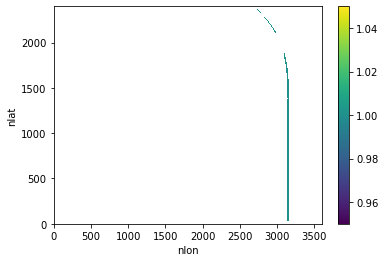

In [19]:
mask_transect150W = ones.where(lons_norm>-156).where(lons_norm<-154)
mask_transect150W.plot()

In [20]:
ds_clim

<xarray.Dataset>
Dimensions:   (month: 12, nlat: 2400, nlon: 3600)
Coordinates:
    z_t       float32 500.0
    z_t_150m  float32 500.0
    TLONG     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    dz        (month) float32 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    Fe        (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    NO3       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    PO4       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    SiO3      (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    DIC       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    TEMP      (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    coccoC    (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    diatC     (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    spC       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

In [21]:
variables

['Fe', 'NO3', 'PO4', 'SiO3', 'DIC', 'TEMP', 'coccoC', 'diatC', 'spC']

In [22]:
ts_clim_transect = xr.Dataset()

transect_vars = variables + ['TLAT']

for v in transect_vars:
    
    ts_clim_transect[v] = esmlab.statistics.weighted_mean(ds_clim[v].where(mask_transect150W==1), weights=area, dim=['nlon'])
    ts_clim_transect[v].attrs = ds[v].attrs

ts_clim_transect = ts_clim_transect.load()

[Text(0, 0.5, 'NO3/SiO3 (mmol m$^{-3}$)'), Text(0.5, 0, 'latitude')]

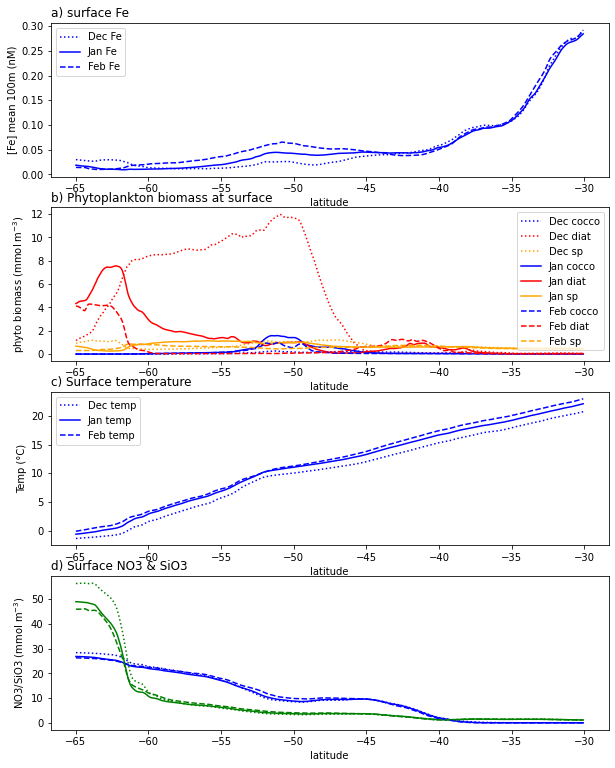

In [23]:
fig = plt.figure(figsize=(10,13))

ax = fig.add_subplot(4,1,1)
ax.set_title('a) surface Fe', loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.Fe.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65)*1000,color='blue',label='Dec Fe',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.Fe.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65)*1000,color='blue',label='Jan Fe')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.Fe.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65)*1000,color='blue',label='Feb Fe',linestyle='--')
ax.set(ylabel='[Fe] mean 100m (nM)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(4,1,2)
ax.set_title('b) Phytoplankton biomass at surface',loc='left')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.coccoC.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue',label='Dec cocco',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.diatC.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='red',label='Dec diat',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.spC.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='orange',label='Dec sp',linestyle=':')


ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.coccoC.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue',label='Jan cocco')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.diatC.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='red',label='Jan diat')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.spC.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='orange',label='Jan sp')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.coccoC.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue',label='Feb cocco',linestyle='--')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.diatC.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='red',label='Feb diat',linestyle='--')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.spC.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='orange',label='Feb sp',linestyle='--')


ax.set(ylabel='phyto biomass (mmol m$^{-3}$)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(4,1,3)
ax.set_title('c) Surface temperature ',loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.TEMP.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue', label='Dec temp',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.TEMP.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue', label='Jan temp')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.TEMP.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue', label='Feb temp',linestyle='--')
ax.set(ylabel='Temp (°C)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(4,1,4)
ax.set_title('d) Surface NO3 & SiO3',loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.NO3.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue', label='Dec NO3',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.SiO3.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='green',label='Dec SiO3',linestyle=':')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.NO3.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue', label='Jan NO3')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.SiO3.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='green',label='Jan SiO3')
        
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.NO3.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='blue', label='Feb NO3',linestyle='--')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.SiO3.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='green',label='Feb SiO3',linestyle='--')
ax.set(ylabel='NO3/SiO3 (mmol m$^{-3}$)',xlabel='latitude')


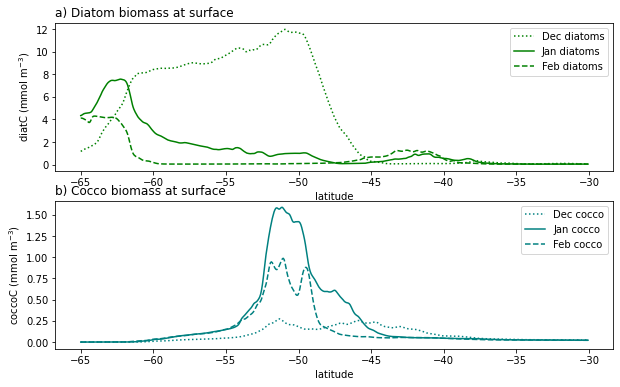

In [24]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(2,1,1)
ax.set_title('a) Diatom biomass at surface', loc='left')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.diatC.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='green',label='Dec diatoms',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.diatC.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='green',label='Jan diatoms')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.diatC.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='green',label='Feb diatoms',linestyle='--')
ax.set(ylabel='diatC (mmol m$^{-3}$)',xlabel='latitude')
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.set_title('b) Cocco biomass at surface',loc='left')

ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.coccoC.isel(month=11).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='teal',label='Dec cocco',linestyle=':')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.coccoC.isel(month=0).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='teal',label='Jan cocco')
ax.plot(ts_clim_transect.TLAT.where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),
        ts_clim_transect.coccoC.isel(month=1).where(ts_clim_transect.TLAT<-30).where(ts_clim_transect.TLAT>-65),color='teal',label='Feb cocco',linestyle='--')

ax.set(ylabel='coccoC (mmol m$^{-3}$)',xlabel='latitude')
ax.legend()




In [25]:
ts_clim_transect

<xarray.Dataset>
Dimensions:   (month: 12, nlat: 2400)
Coordinates:
    z_t       float32 500.0
    z_t_150m  float32 500.0
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat
Data variables:
    Fe        (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    NO3       (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    PO4       (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    SiO3      (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    DIC       (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    TEMP      (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    coccoC    (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    diatC     (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    spC       (month, nlat) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLAT      (nlat) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [26]:
file = '/glade/scratch/kristenk/month_clim_transect_x0.1_4p2z_150W_surface.nc'
ts_clim_transect.to_netcdf(file)

In [27]:
cluster.close()